In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import ipyplot
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from collections import defaultdict
import os

In [11]:
from tensorflow_similarity.samplers import SingleShotMemorySampler
from tensorflow_similarity.augmenters import SimCLRAugmenter
from tensorflow_similarity.models import ContrastiveModel
from tensorflow_similarity.losses import SiamSiamLoss
from tensorflow_similarity.training_metrics import encoder_std  ## siam siam metric
from tensorflow_similarity.visualization import visualize_views

# dataset

## loading

In [12]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
print("x_train", x_train.shape, "x_test", x_test.shape)
y_train = keras.utils.to_categorical(y_train, 100)
y_test = keras.utils.to_categorical(y_test, 100)
print("y_train", y_train.shape, "y_test", y_test.shape)

x_train (50000, 32, 32, 3) x_test (10000, 32, 32, 3)
y_train (50000, 100) y_test (10000, 100)


In [14]:
IMG_SIZE = 32
PRE_TRAIN_IMGS = 128
TRAIN_BATCH_SIZE = 64

In [15]:
train_augmenter = SimCLRAugmenter(IMG_SIZE,IMG_SIZE, is_training=True)
#     #test_augmenter = SimCLRAugmenter(IMG_SIZE,IMG_SIZE, is_training=False)
sampler = SingleShotMemorySampler(x_train, examples_per_batch=PRE_TRAIN_IMGS, augmenter=train_augmenter, num_augmentations_per_example=2)


The initial batch size is 384 (128 classes * 1 examples per class) with 2 augmenters


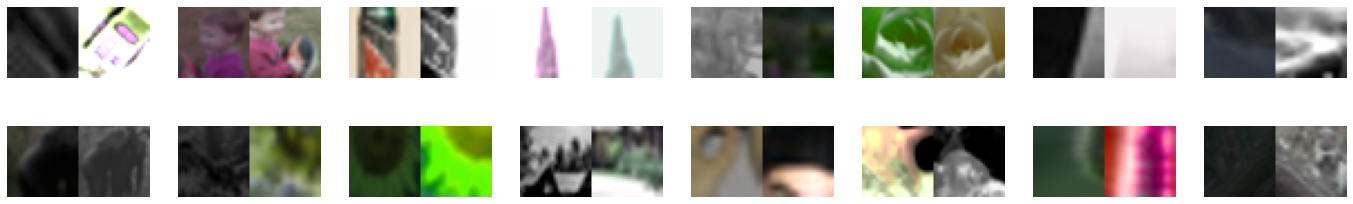

In [32]:
views = sampler.generate_batch(0)

visualize_views(views=views, num_imgs=16, views_per_col=8)

# Models

## backbone 

In [33]:
def get_encoder(IMG_SIZE):
	base_model = tf.keras.applications.ResNet50V2(include_top=False,
		weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3))
	base_model.trainable = True

	inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
	# no rescaling as efficientnet do it for you
	x = base_model(inputs, training=True)
 
 	# < this is the representation
	o = layers.GlobalAveragePooling2D()(x) 
	backbone = Model(inputs, o, name='encoder')
	return backbone
encoder = get_encoder(IMG_SIZE)
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 1, 1, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
Total params: 23,564,800
Trainable params: 23,519,360
Non-trainable params: 45,440
_________________________________________________________________


## projector model

In [34]:
def get_projector(dim, activation='relu'):
    inputs = layers.Input(shape=(dim,))
    x = layers.Dense(dim, activation=activation)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(dim, activation=activation)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(dim)(x)
    x = layers.BatchNormalization()(x)
    projector = Model(inputs, x, name="projector")
    return projector

projector = get_projector(2048)
projector.summary()

Model: "projector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              81

# Loss

In [35]:
loss = SiamSiamLoss
metrics = [[encoder_std], []]

In [36]:
PRE_TRAIN_EPOCHS = 1
STEPS_PER_EPOCH = 1000
contrastive_model = ContrastiveModel(encoder_model=encoder, 
                         projector_model=projector, 
                         swap_representation=True)
# use sgd as optimizer with constant loss as recommende in the paper.
contrastive_model.compile('sgd', loss=SiamSiamLoss, metrics=metrics)
contrastive_history = contrastive_model.fit(sampler, epochs=PRE_TRAIN_EPOCHS, steps_per_epoch=STEPS_PER_EPOCH)

  60/1000 [>.............................] - ETA: 3:09 - loss: 1.6451 - output_1_encoder_std: 0.0182

KeyboardInterrupt: 

# Evaluation

In [ ]:
TEST_EPOCHS = 10

# No pretrain

In [ ]:
# FIXME move to before pre-train
no_encoder = get_encoder(IMG_SIZE)

inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
x = no_encoder(inputs, training=True)
o = layers.Dense(10, activation='softmax')(x)
reg_model = Model(inputs, o, name='no_pretrain')

reg_model.compile('adam', loss='categorical_crossentropy', metrics=['acc'])
reg_history = reg_model.fit(x_train, y_train, batch_size=TRAIN_BATCH_SIZE, epochs=TEST_EPOCHS, validation_data=(x_test, y_test))

In [ ]:
# pretrained with SiamSiam

In [ ]:
encoder = contrastive_model.get_encoder()

inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
x = encoder(inputs)
o = layers.Dense(10, activation='softmax')(o)
pre_model = Model(inputs, o, name='pretrained')

pre_model.compile('adam', loss='categorical_crossentropy', metrics=['acc'])
pre_history = pre_model.fit(x_train, y_train, batch_size=TRAIN_BATCH_SIZE, epochs=TEST_EPOCHS, validation_data=(x_test, y_test))

In [ ]:
print('no pretrain', reg_model.evaluate(x_train, y_test))
print('pretrained', pre_model.evaluate(x_test, y_test))